# MLP for complete TF
In this case, we are going to predict the complete TF function

In [126]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [127]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 1000
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)


(188, 256) (188,)


In [128]:
# Use only certain Vs
idx = np.random.choice(range(len(Vs_data)), 400)
TTF_values = TTF_data[idx]
Vs_values = Vs_data[idx]
print(TTF_values.shape, Vs_values.shape)

(400, 256) (400,)


In [129]:
# Normalize the data
def normalize_data(data, mean, std):
    return (data - mean) / std

def denormalize_data(data, mean, std):
    return data * std + mean

# Normalize the data
mean_Vs = Vs_values.mean()
std_Vs = Vs_values.std()
mean_TTF = TTF_values.mean()
std_TTF = TTF_values.std()

Vs_values = normalize_data(Vs_values, mean_Vs, std_Vs)
TTF_values = normalize_data(TTF_values, mean_TTF, std_TTF)

In [130]:
class TTFDataset(Dataset):
    def __init__(self, TTF_data, Vs_array):
        self.TTF_data = TTF_data
        self.Vs_array = Vs_array

    def __len__(self):
        return len(self.TTF_data)

    def __getitem__(self, idx):

        # Input 
        Vs = self.Vs_array[idx] * np.ones(30)
        input_data = Vs
        input_data = torch.tensor(input_data, dtype=torch.float32)

        # Target
        TTF = self.TTF_data[idx,:]
        target = torch.tensor(TTF, dtype=torch.float32)

        return input_data, target

In [131]:
# Create dataset
dataset = TTFDataset(TTF_values, Vs_values)

# Create dataloader
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print("Number of samples: ", len(train_dataset), len(val_dataset), len(test_dataset))

# Create dataloader
i_batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))



Number of samples:  320 40 40
Number of batches:  2 1 1


In [132]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [133]:
# Define Transformer
class Transformer(nn.Module):
    def __init__(self, encoder_hidden_dim, encoder_hidden_size, decoder_hidden_dim, decoder_hidden_size, input_dim, output_dim, latent_dim):
        super(Transformer, self).__init__()

        self.encoder = MLP(input_dim, encoder_hidden_dim, encoder_hidden_size, latent_dim, batch_norm=True)
        self.decoder = MLP(latent_dim, decoder_hidden_dim, decoder_hidden_size, output_dim, batch_norm=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [134]:
model = Transformer(128, 5, 128, 5, 30, 256, 5)
loss_fn = nn.MSELoss()
X,y = next(iter(train_loader))
print(X.shape, y.shape)
pred = model(X)
assert pred.shape == y.shape , f"Expected shape {y.shape} but got {pred.shape}"
print("Loss: ", loss_fn(pred, y))

torch.Size([200, 30]) torch.Size([200, 256])
Loss:  tensor(1.3171, grad_fn=<MseLossBackward0>)


In [135]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [136]:
import torch
from tqdm import tqdm, trange
import torch.nn as nn
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50):
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 250 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model

In [137]:
# Define test function
def test(model, test_dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [138]:
# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [139]:
model

Transformer(
  (encoder): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=30, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (out): Linear(in_features=128, out_features=5, bias=True)
  )
  (decoder): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=5, o

In [140]:
# Model
model = Transformer(128, 3, 128, 3, 30, 256, 50)

# Xavier Glore initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Loss function - RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

In [141]:
# Optimizer with momentum NAG
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.01, nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.6, 0.6), weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.9, eps=1e-08, weight_decay=0.01, momentum=0.9, centered=False)


# Scheduler with exponential decay
#scheduler = None
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

In [142]:
# Train model
train_losses, val_losses, model = train(model, optimizer, scheduler, train_loader, val_loader, loss_fn, epochs=10000, device=device, patience=2500)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Epoch 0, Train Loss: 1.2441042065620422, Val Loss: 1.0023940801620483, LR: 0.009498833469170485


Training:   3%|▎         | 256/10000 [00:06<04:44, 34.20epoch/s, EarlyStopping counter: 35 out of 2500]

Epoch 250, Train Loss: 0.4287284165620804, Val Loss: 0.39148852229118347, LR: 0.009801195391584295


Training:   5%|▌         | 508/10000 [00:14<04:22, 36.15epoch/s, EarlyStopping counter: 122 out of 2500]

Epoch 500, Train Loss: 0.3381003737449646, Val Loss: 0.33786892890930176, LR: 0.009828188973619567


Training:   8%|▊         | 756/10000 [00:20<03:45, 40.93epoch/s, EarlyStopping counter: 193 out of 2500]

Epoch 750, Train Loss: 0.33683518320322037, Val Loss: 0.43712055683135986, LR: 0.009778281370233996


Training:  10%|█         | 1008/10000 [00:27<03:38, 41.08epoch/s, EarlyStopping counter: 241 out of 2500]

Epoch 1000, Train Loss: 0.34078504145145416, Val Loss: 0.3988126814365387, LR: 0.009797513967600124


Training:  13%|█▎        | 1256/10000 [00:33<03:39, 39.80epoch/s, EarlyStopping counter: 197 out of 2500]

Epoch 1250, Train Loss: 0.30814129114151, Val Loss: 0.45917263627052307, LR: 0.009767227176437741


Training:  15%|█▌        | 1506/10000 [00:40<03:51, 36.65epoch/s, EarlyStopping counter: 446 out of 2500]

Epoch 1500, Train Loss: 0.3938102722167969, Val Loss: 0.3460093140602112, LR: 0.00982408609773973


Training:  18%|█▊        | 1756/10000 [00:47<03:34, 38.38epoch/s, EarlyStopping counter: 124 out of 2500]

Epoch 1750, Train Loss: 0.3707430511713028, Val Loss: 0.4690497815608978, LR: 0.00976228004652128


Training:  20%|██        | 2005/10000 [00:54<03:32, 37.63epoch/s, EarlyStopping counter: 184 out of 2500]

Epoch 2000, Train Loss: 0.23768819868564606, Val Loss: 0.4132464826107025, LR: 0.009790262991954382


Training:  23%|██▎       | 2258/10000 [01:01<03:37, 35.54epoch/s, EarlyStopping counter: 435 out of 2500]

Epoch 2250, Train Loss: 0.4670803099870682, Val Loss: 0.4789442718029022, LR: 0.009757326741441497


Training:  25%|██▌       | 2505/10000 [01:07<03:32, 35.22epoch/s, EarlyStopping counter: 683 out of 2500]

Epoch 2500, Train Loss: 0.41284921765327454, Val Loss: 0.6079115867614746, LR: 0.009692993500867154


Training:  28%|██▊       | 2755/10000 [01:14<03:14, 37.15epoch/s, EarlyStopping counter: 934 out of 2500]

Epoch 2750, Train Loss: 0.28844432532787323, Val Loss: 0.47873011231422424, LR: 0.009757433925734622


Training:  30%|███       | 3006/10000 [01:21<03:09, 36.93epoch/s, EarlyStopping counter: 96 out of 2500]  

Epoch 3000, Train Loss: 0.28633060306310654, Val Loss: 0.414624959230423, LR: 0.009789570780148242


Training:  33%|███▎      | 3254/10000 [01:28<03:18, 33.93epoch/s, EarlyStopping counter: 345 out of 2500]

Epoch 3250, Train Loss: 0.25158316642045975, Val Loss: 0.34581032395362854, LR: 0.009824186371304399


Training:  35%|███▌      | 3504/10000 [01:36<03:09, 34.36epoch/s, EarlyStopping counter: 595 out of 2500]

Epoch 3500, Train Loss: 0.3944554775953293, Val Loss: 0.4727734327316284, LR: 0.009760415645334216


Training:  38%|███▊      | 3755/10000 [01:42<03:04, 33.78epoch/s, EarlyStopping counter: 843 out of 2500]

Epoch 3750, Train Loss: 0.2975376546382904, Val Loss: 0.4598965346813202, LR: 0.009766864514946854


Training:  40%|████      | 4003/10000 [01:53<09:13, 10.84epoch/s, EarlyStopping counter: 1090 out of 2500]

Epoch 4000, Train Loss: 0.2827427461743355, Val Loss: 0.5278932452201843, LR: 0.009732859222102274


Training:  43%|████▎     | 4253/10000 [02:14<07:46, 12.32epoch/s, EarlyStopping counter: 1340 out of 2500]

Epoch 4250, Train Loss: 0.28492430597543716, Val Loss: 0.4197003245353699, LR: 0.009787022571289102


Training:  45%|████▌     | 4502/10000 [02:36<07:55, 11.56epoch/s, EarlyStopping counter: 1590 out of 2500]

Epoch 4500, Train Loss: 0.30899909138679504, Val Loss: 0.36768466234207153, LR: 0.009813169748139434


Training:  48%|████▊     | 4756/10000 [02:43<02:24, 36.32epoch/s, EarlyStopping counter: 1845 out of 2500]

Epoch 4750, Train Loss: 0.2638722062110901, Val Loss: 0.5778020620346069, LR: 0.009707975087983831


Training:  50%|█████     | 5003/10000 [02:56<06:42, 12.42epoch/s, EarlyStopping counter: 2090 out of 2500]

Epoch 5000, Train Loss: 0.266401045024395, Val Loss: 0.41974905133247375, LR: 0.009786998110047015


Training:  53%|█████▎    | 5255/10000 [03:15<02:35, 30.49epoch/s, EarlyStopping counter: 2343 out of 2500]

Epoch 5250, Train Loss: 0.2774200364947319, Val Loss: 0.4598909914493561, LR: 0.00976686729196598


Training:  54%|█████▍    | 5412/10000 [03:21<02:50, 26.90epoch/s, EarlyStopping counter: 2500 out of 2500]

Early stopping


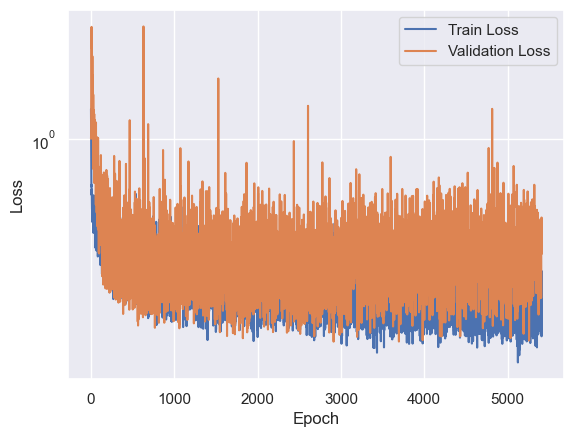

In [143]:
# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [144]:
# Test the model
test_loss = test(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.43453726172447205


In [145]:
# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())

predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)

# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)

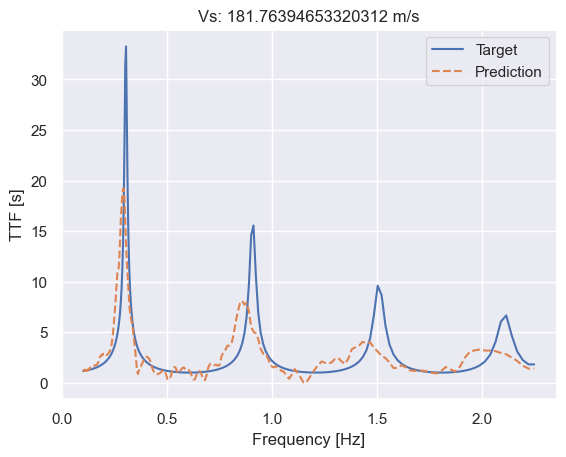

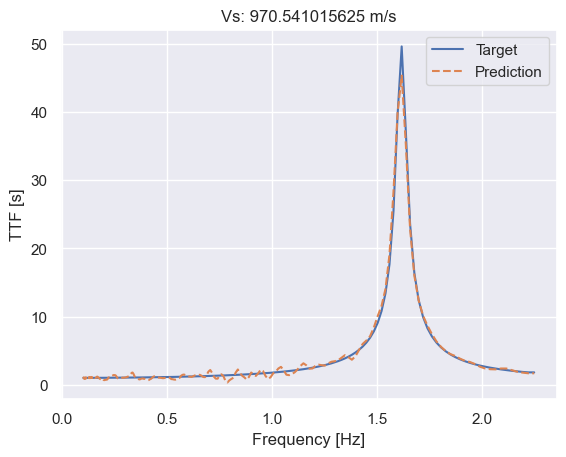

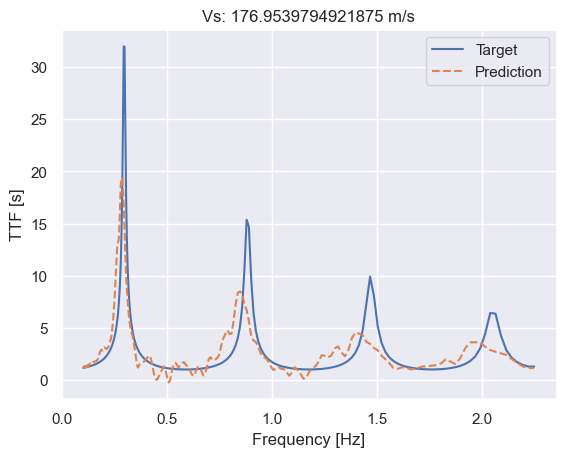

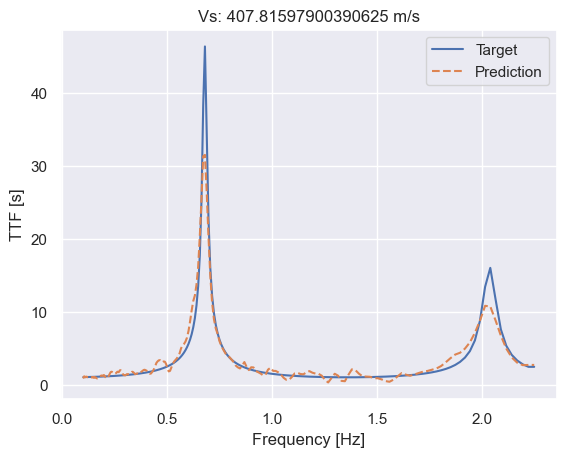

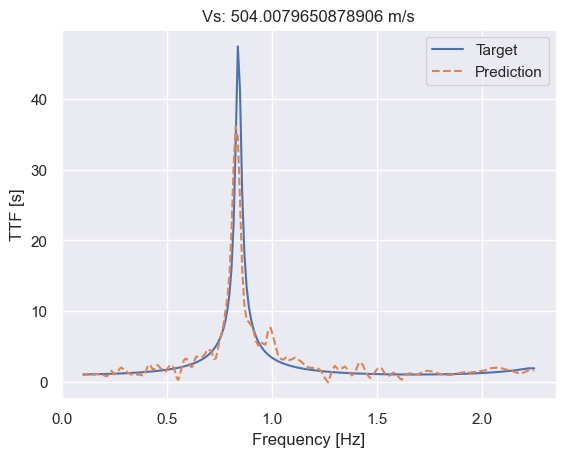

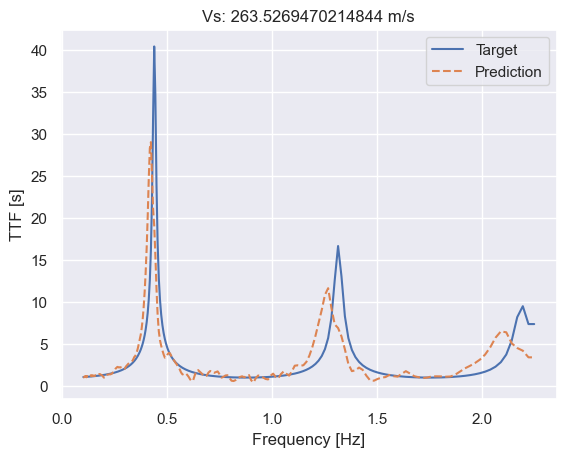

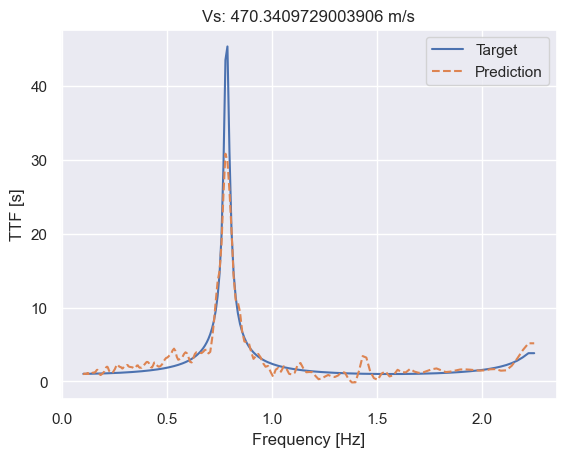

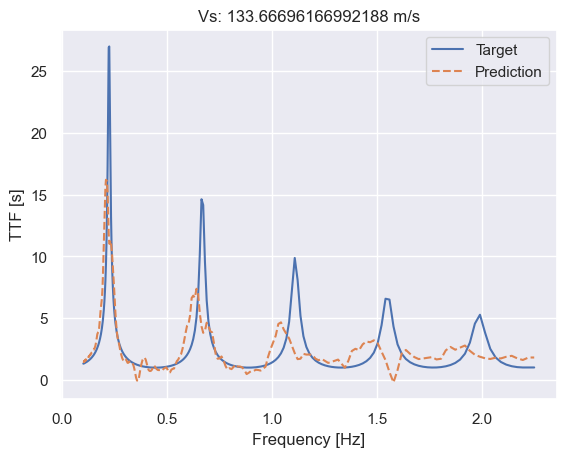

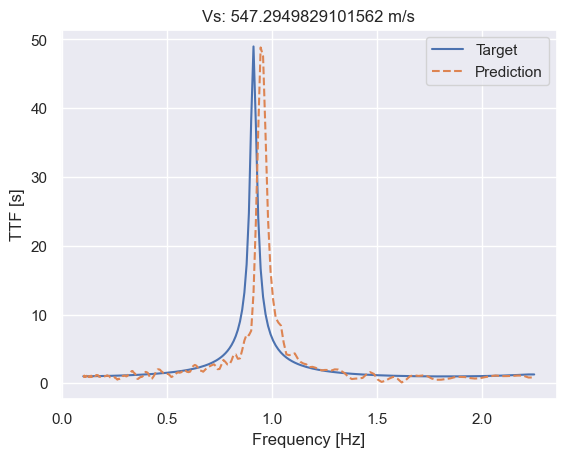

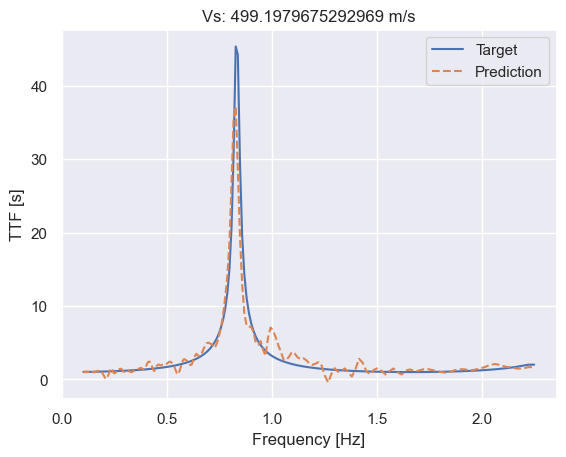

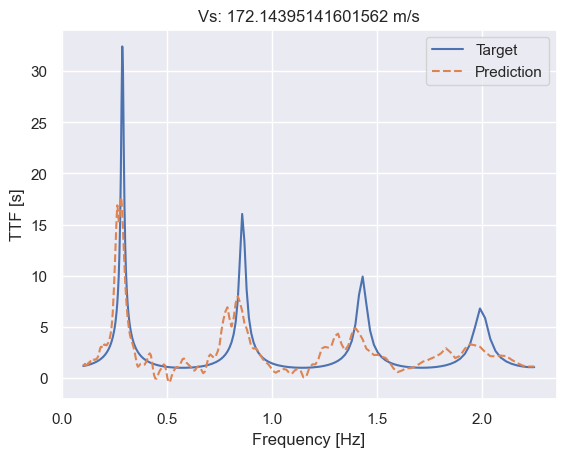

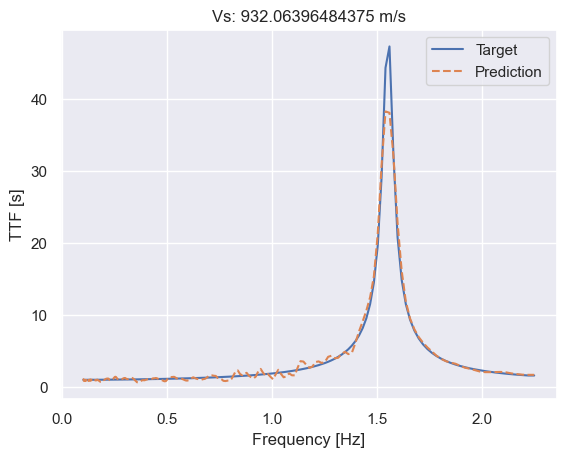

In [146]:
for idx in range(target.shape[0]):
    plt.plot(freq_data,target[idx], label="Target")
    plt.plot(freq_data,predictions[idx], label="Prediction", linestyle="--")
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TTF [s]")
    plt.title(f"Vs: {Vs_target[idx]} m/s")
    plt.show()
    if idx > 10:
        break

In [147]:
# Save model
torch.save(model.state_dict(), "transformer_model.pt")

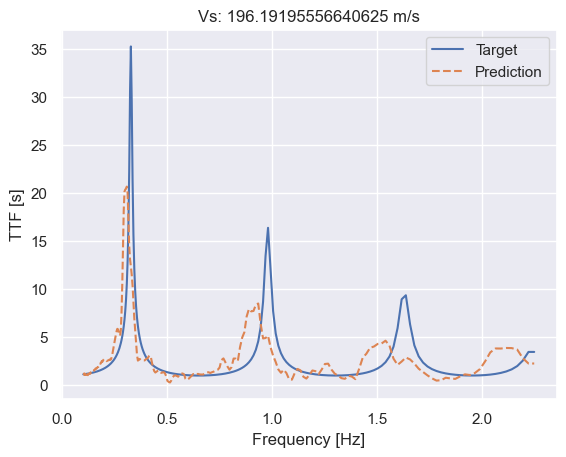

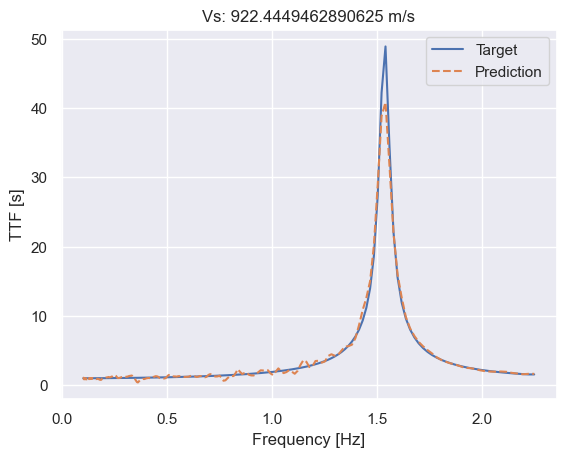

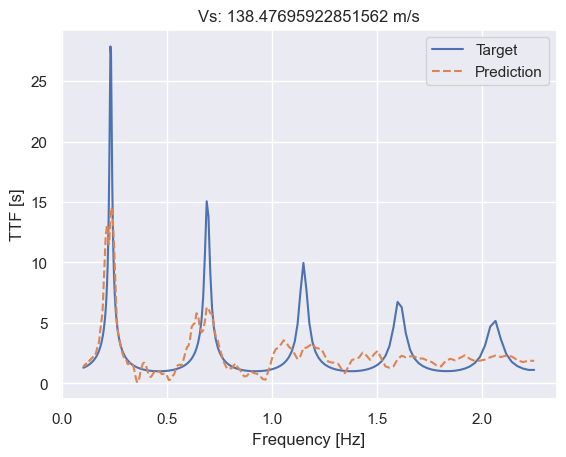

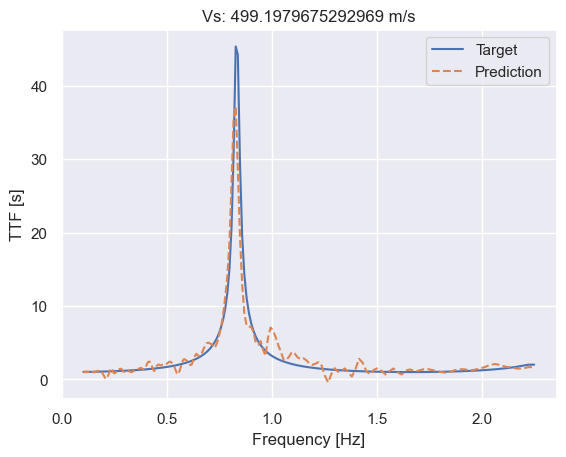

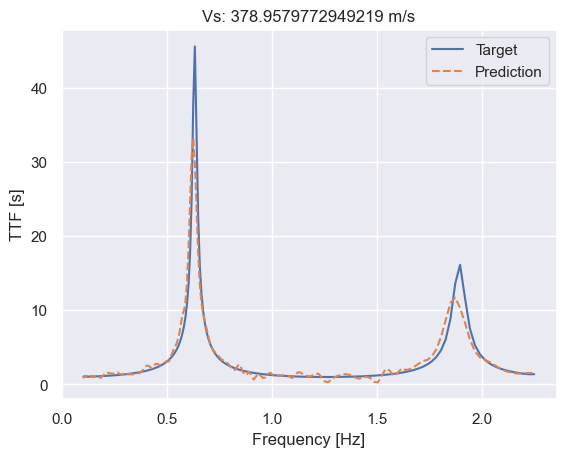

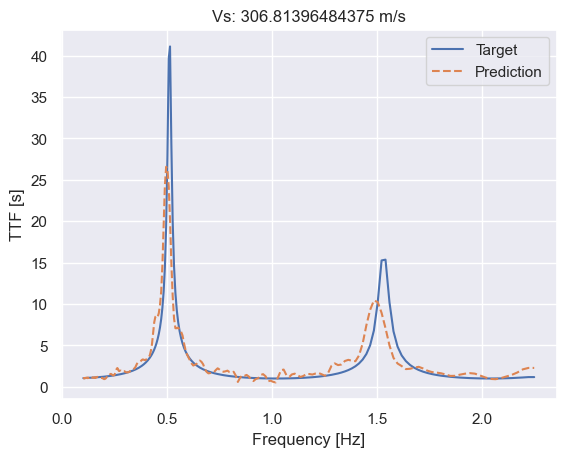

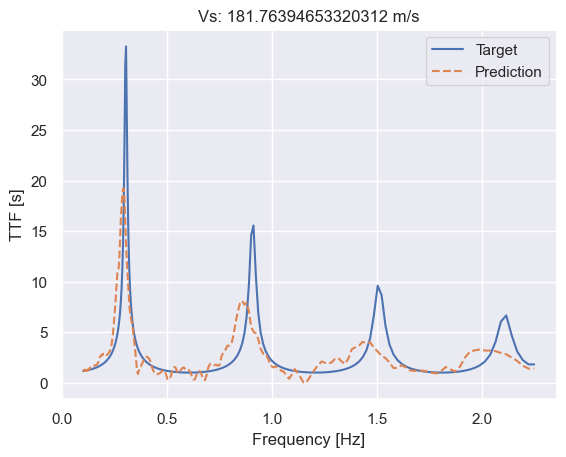

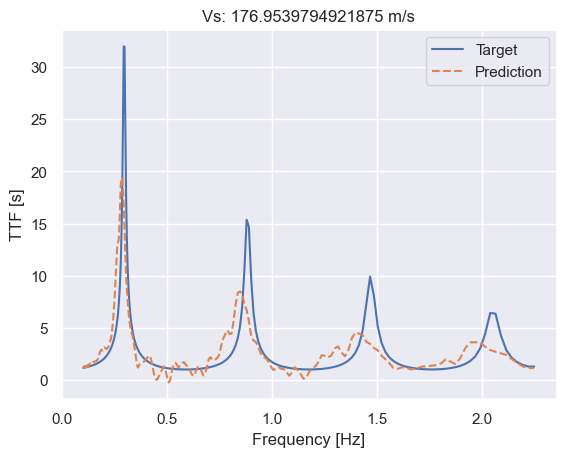

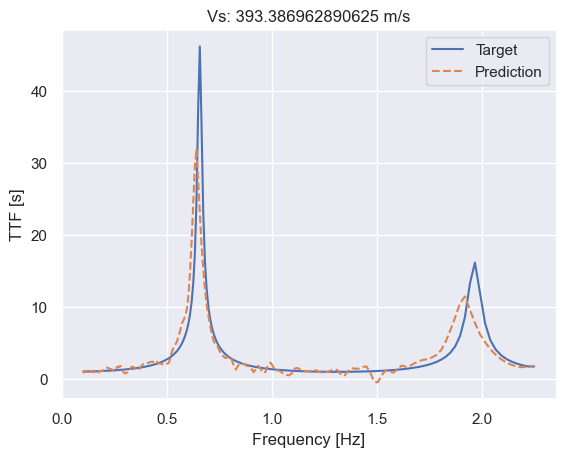

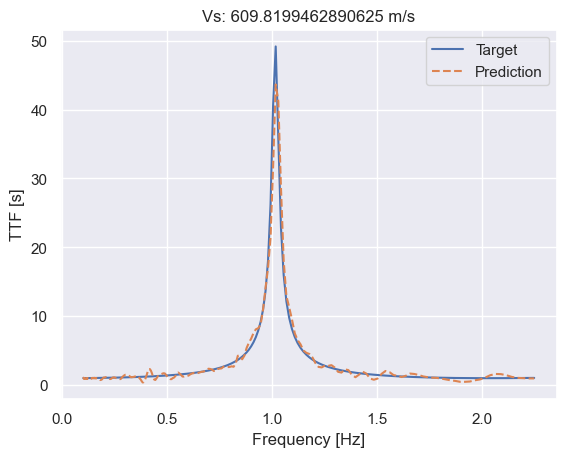

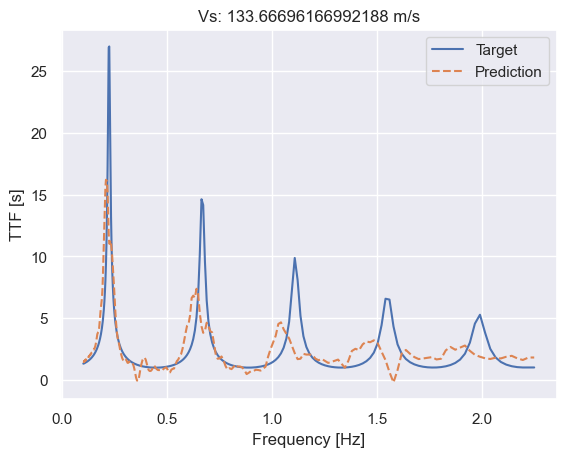

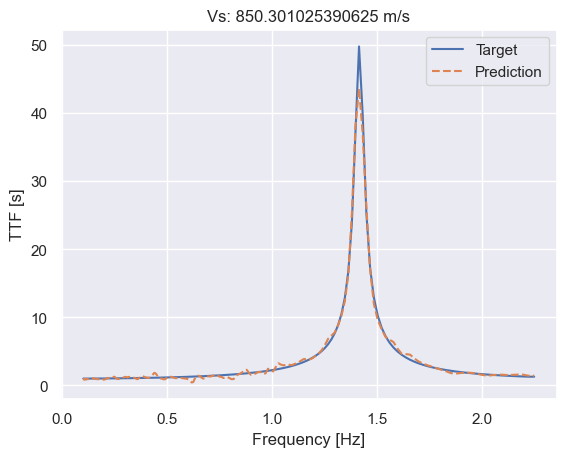

In [148]:
# Load model
model = Transformer(128, 3, 128, 3, 30, 256, 50)
model.load_state_dict(torch.load("transformer_model.pt"))

# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []

with torch.no_grad():
    model.to(device)
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())

predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)

# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)

for idx in range(target.shape[0]):
    plt.plot(freq_data,target[idx], label="Target")
    plt.plot(freq_data,predictions[idx], label="Prediction", linestyle="--")
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TTF [s]")
    plt.title(f"Vs: {Vs_target[idx]} m/s")
    plt.show()
    if idx > 10:
        break